# Exploring the capability of neural networks to solve simple linear and nonlinear algebraic equations.

![squeeze](squeeze.png)

Topics covered:
- PyTorch
- Feature Crosses
- Linear and nonlinear models
- universal approximation theorem
- interpreting loss curves

In this example, I asked chat GPT to *generate a PyTorch training loop for a linear model, from a synthetic dataset*. The code produced was great. It gave me ideas and some framework code from which to develop my own understanding.  Modifying and developing the code was a quick way to explore some new functions and explore some ideas in an interactive way. 

I wanted to get an intuitive understanding of the universal approximation theorem, in order to be able to better decide when to choose a neural network, and when to choose another type of model. 

# Part 1: using the original solution from Chat GPT
Here's the original code which was returned by GPT3.

This code will run, but the model won't reach an optimal solution with only 10 epochs to train. 

In the rest of the notebook I modified this code to provide graphs of the loss over time, and convert this linear model into a higher order model.

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Generate a synthetic dataset
X = torch.randn(100, 10)
y = 2 * X[:, 0] - 3 * X[:, 1] + 1
dataset = TensorDataset(X, y)

# Define the model
model = torch.nn.Linear(10, 1)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loader
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Train the model
for epoch in range(10):
    for batch_X, batch_y in loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the model's predictions
        preds = model(batch_X)

        # Compute the loss
        loss = loss_fn(preds.squeeze(), batch_y)

        # Backpropagate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

    print(f"Epoch {epoch}: loss={loss.item()}")

# Evaluate the model on a test set
test_X = torch.randn(10, 10)
test_y = 2 * test_X[:, 0] - 3 * test_X[:, 1] + 1
test_preds = model(test_X)
test_loss = loss_fn(test_preds.squeeze(), test_y)
print(f"Test loss: {test_loss.item()}")

Epoch 0: loss=22.493709564208984
Epoch 1: loss=30.124778747558594
Epoch 2: loss=3.1588780879974365
Epoch 3: loss=0.5278647541999817
Epoch 4: loss=2.054234504699707
Epoch 5: loss=1.3800737857818604
Epoch 6: loss=1.5628712177276611
Epoch 7: loss=1.615380048751831
Epoch 8: loss=0.6866233944892883
Epoch 9: loss=0.4222300052642822
Test loss: 1.534257173538208


We can see that the loss decreases consistently. Training the model for longer will provide more chance to converge. We can plot the loss per epoch to see how the trianing process behaves. 

Text(0.5, -0.3, 'x1')

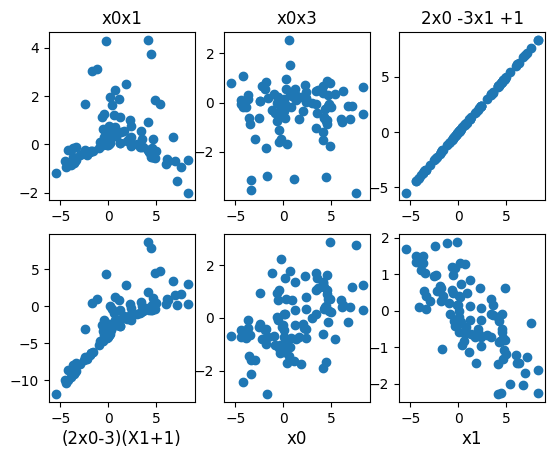

In [2]:
plt.subplot(231)
plt.scatter(y, X[:,0] * X[:,1])
plt.title('x0x1')
plt.subplot(232)
plt.scatter(y, X[:,0] * X[:,3])
plt.title('x0x3')
plt.subplot(233)
plt.scatter(y, 2 * X[:, 0] - 3 * X[:, 1] + 1)
plt.title('2x0 -3x1 +1')
plt.subplot(234)
plt.scatter(y, (2 * X[:,0] - 3) * (X[:,1] + 1))
plt.title('(2x0-3)(X1+1)', y=-0.3)
plt.subplot(235)
plt.scatter(y, X[:,0])
plt.title('x0', y=-0.3)
plt.subplot(236)
plt.scatter(y, X[:,1])
plt.title('x1', y=-0.3)

- The input X has the shape 100 x 10, so there are 100 rows and 10 columns in the input features X.
- We can call each column of X a different feature, each feature is available to the model. So the first column is X<sub>0 </sub> and the second column is X<sub>1 </sub> etc
- The only features which have an effect on the dependent variable y are the first two columns. The remaining 8 columns are just random number arrays, but they're still included as inputs to the model. 
- The relation between the independent variable X and the dependent variable y is:

$y=2X_0-3X_1+1$

So after sufficient training, the model should converge towards a set of parameters where the first two values are 2, -3, and the rest of the parameters are zero. The bias should be 1.

In [3]:
model.weight, model.bias

(Parameter containing:
 tensor([[ 1.4036, -2.0332, -0.0699, -0.1619, -0.1036, -0.1896,  0.1699, -0.1857,
          -0.0743,  0.1273]], requires_grad=True),
 Parameter containing:
 tensor([0.8477], requires_grad=True))

# Here's a modified training loop which keeps a record of the loss per epoch
We can reset the model parameters by trying out PyTorch's reset_parameters() method. First let's make sure the method works. Here's a [great stackoverflow post about initializing weights in pytorch](https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch) - check out ashunigion's answer to get an idea for good initial values for the model parameter (tldr: make the parameters between -y and y where y is $1\div{sqrt(n)}$ and n is the number of inputs to a given neuron.

# First reset the model parameters

In [4]:
model.reset_parameters()
model.weight, model.bias

(Parameter containing:
 tensor([[-0.1250,  0.0685, -0.0427, -0.1533, -0.1290, -0.2668, -0.0173,  0.0060,
           0.2563,  0.2472]], requires_grad=True),
 Parameter containing:
 tensor([0.2434], requires_grad=True))

The parameters have been randomized again. They seem to lie between about -0.3 and 0.3, which is good. We want the parameters to be small but not too close to zero.

# Then re-train the model for more epochs and print the loss curves. 

Epoch 9: loss=0.7730153203010559
Epoch 19: loss=0.10954589396715164
Epoch 29: loss=0.02015821449458599
Epoch 39: loss=0.006337662227451801
Epoch 49: loss=0.0010666173184290528
Epoch 59: loss=0.00014847215788904577
Epoch 69: loss=7.933216693345457e-05
Epoch 79: loss=6.406212196452543e-05
Epoch 89: loss=1.842682650021743e-06
Epoch 99: loss=1.1539671049831668e-06


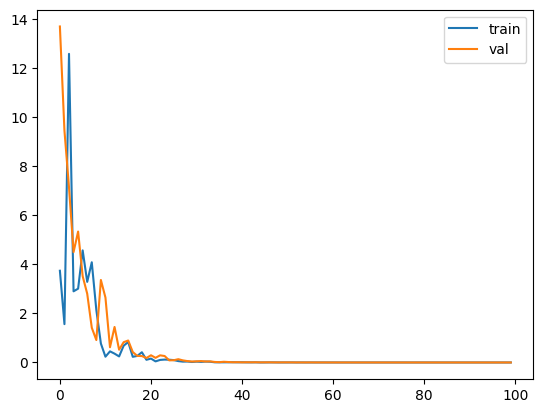

In [5]:
# Train the model
epochs = 100
train_losses = []
validation_losses = []
for epoch in range(epochs):
    for batch_X, batch_y in loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the model's predictions
        preds = model(batch_X)

        # Compute the loss
        loss = loss_fn(preds.squeeze(), batch_y)
    

        # Backpropagate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()
    
    train_losses.append(loss.item())
    
    # Evaluate the model on a test set
    test_X = torch.randn(10, 10)
    test_y = 2 * test_X[:, 0] - 3 * test_X[:, 1] + 1
    test_preds = model(test_X)
    test_loss = loss_fn(test_preds.squeeze(), test_y)
    validation_losses.append(test_loss.item())
        
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), validation_losses, label='val')
plt.legend()


In [6]:
model.weight, model.bias

(Parameter containing:
 tensor([[ 1.9994e+00, -2.9997e+00, -3.6080e-04, -5.8352e-04, -9.7807e-04,
          -2.4436e-04,  1.1536e-05,  1.3589e-04,  1.0097e-04,  3.8863e-04]],
        requires_grad=True),
 Parameter containing:
 tensor([0.9999], requires_grad=True))

# Great! We can see that the model converges towards the optimal solution for this linear input. 

We're looking for 

$w_0 = 2 $<br>
$w_1 = -3$<br>
$b = 1$<br>

and the parameters of the model are pretty close.


We were able to generate a new validation set each epoch - since we're using a synthetic dataset. In real life we'd have taken a sample from the training data and use this for validation.

# Part 2: Let's use this code to train a different type of model.

<font color='blue'>__In this example the dependent varaible is calculated using the product of $X_0$ and $X_1$__</font>


# Equations
In this section, the dependent variable y is again a function of the independent variable X, but it is calculated using the product of $X_0$ and $X_1$

$y = (2X_0-3)(X_1 + 1)$

- Expanding the brackets gives 

$y=2X_0X_1 + 2X_0 -3X_1 - 3$

# Generate a synthetic dataset with the new dependent variable

__In this example the dependent varaible is proportional to the product $X_0$ and $X_1$__
At first this won't be available to our linear model, and we'll see what effect this has on the model's ability to converge towards optimal values for the weights and biases. 


In [7]:
X = torch.randn(1000, 10)
y = (2 * X[:, 0] - 3) * (X[:, 1] + 1)

# Split the training data into a validation and test set. 

In [8]:
train_x, train_y = X[:800], y[:800]
val_x, val_y     = X[800:], y[800:]
train_dataset = TensorDataset(train_x, train_y)

The dataset contains pairs of input features and labels stored as an iterable of tuples.

The DataLoader object loader returns batches of examples from the dataset.

In [9]:
# Define the data loader
loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



- The training set __x__ has the shape 800 x 10, so there are 800 rows and 10 columns for this feature matrix.
- We can call each column of __x__ a different feature. Each feature is seen by the model. So the first item is __x<sub>0 </sub>__ and the second feature is __x<sub>1 </sub>__ etc
- The only features which have an effect on the dependent variable y are the first two columns. The remaining 8 columns are just random number arrays, but they're still inputted to the model. 



We can make plots to see which features have an effect on the dependent variable __y__. 

Text(0.5, -0.3, 'x1')

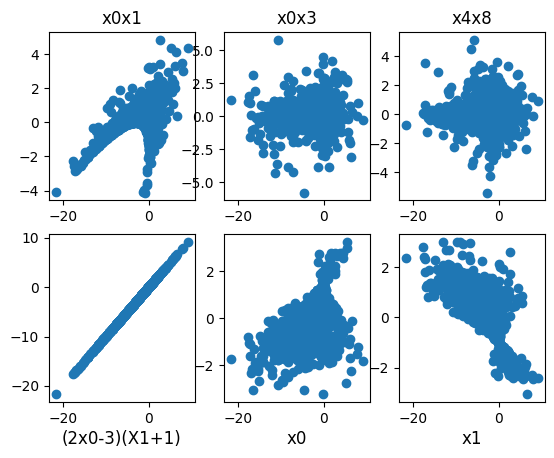

In [10]:
plt.subplot(231)
plt.scatter(y, X[:,0] * X[:,1])
plt.title('x0x1')
plt.subplot(232)
plt.scatter(y, X[:,0] * X[:,3])
plt.title('x0x3')
plt.subplot(233)
plt.scatter(y, X[:,4] * X[:,8])
plt.title('x4x8')
plt.subplot(234)
plt.scatter(y, (2 * X[:,0] - 3) * (X[:,1] + 1))
plt.title('(2x0-3)(X1+1)', y=-0.3)
plt.subplot(235)
plt.scatter(y, X[:,0])
plt.title('x0', y=-0.3)
plt.subplot(236)
plt.scatter(y, X[:,1])
plt.title('x1', y=-0.3)

As expected, plotting __y__ against various combinations of X<sub>1</sub> and X<sub>2</sub> reveals correlation between the variables. 

Including other variables such as X<sub>3</sub> and X<sub>8</sub> makes a noisy plot, because these features are just random numbers which have no bearing on y. 

The line y=x is shown in the 4th image. The 2nd and 3rd images show random distributions and the rest of them show correlation of some sort. The relation between y and x in the last two plots doesn't appear to be a linear one. 


So the job of our linear model will be to optimize the weights and bias to pick out the relevant columns from X, and to find the coefficients of these columns which best map to y. 

From the equations above we know that the coefficients are 
- w=2 and for feature X[:, 0] 

and 
- w=-3, for feature X[:, 1]

and the bias should be -3

Additionally y is proportional to $X_0X_1$

# Run the same linear model on this new data

In [11]:
# Define the model
model = torch.nn.Linear(10, 1)

The model describes a linear transformation of 10 input features into one output feature. It multiplies each input feature by a different coefficient, adds a bias to them all, and returns one output. This one output will be calculated for each of the 1000 rows in X.

The feature X is defined as X = torch.randn(1000, 10)


This means there are 1000 examples, each of which has 10 features.


#### Here are the 10 randomly initialised parameters of the model - before any training has been done.

In [12]:
model.weight.data, model.bias.data

(tensor([[ 0.0244, -0.1628, -0.0130, -0.2685, -0.0203, -0.2626, -0.0688,  0.3037,
          -0.1242, -0.2441]]),
 tensor([-0.1494]))

# Custom model weights

Setting custom weights is possible by passing in a tensor of weights into model.weights.data. The tensor has to be a matrix so we pass in a dimension of length 10 and a second dimension of length 1. 


It can also be done by using the zero_ inplace method.

This is only shown as an example - random initialization is probably a safer place to begin training. 

In [13]:
# model.weight.data = torch.zeros(1,10)
# model.weight.data.zero_()

# Loss function and optimizer

In [14]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

In [15]:
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training Loop

# Make a general training loop for the rest of the experiments
For each training loop, we'll need to input a loader object to load items from the training data, a model, and specify the number of epochs the model should train for. 

Additionally we'll split the data into validation and training set rather than generating a new set of test data each epoch. 

In [16]:
def train(epochs, loader, model, val_x, val_y, print_losses=False):    
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    epochs = epochs
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        for batch_X, batch_y in loader:
            
            # Zero the gradients
            optimizer.zero_grad()

            # Compute the model's predictions
            preds = model(batch_X)

            # Compute the loss
            loss = loss_fn(preds.squeeze(), batch_y)

            # Backpropagate the gradients
            loss.backward()

            # Update the weights
            optimizer.step()

        train_losses.append(loss.item())

        # Evaluate the model on the validation set
        val_preds = model(val_x)
        val_loss = loss_fn(val_preds.squeeze(), val_y)
        validation_losses.append(val_loss.item())


        if (epoch+1) % 10 == 0 and print_losses:
            print(f"Epoch {epoch}: losses={[loss.item(), val_loss.item()]}")

    plt.plot(range(epochs), train_losses, label='train')
    plt.plot(range(epochs), validation_losses, label='val')
    plt.legend()
    print(f'{loss.item():.3f}, {val_loss.item():.3f}')

3.676, 2.721


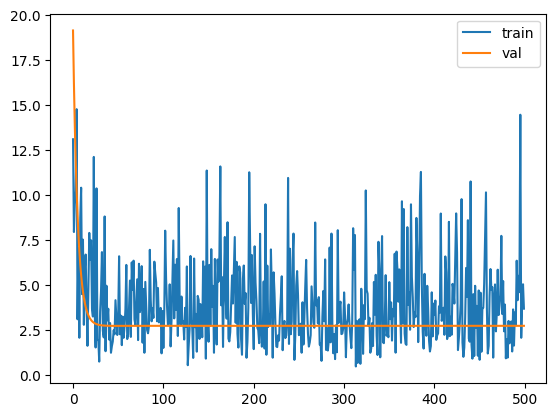

In [17]:
train(500, loader, model, val_x, val_y)

In [18]:
model.weight.data, model.bias.data

(tensor([[ 1.9617, -3.0287,  0.0552,  0.0051, -0.0072, -0.0304,  0.1258, -0.1729,
           0.1352, -0.0153]]),
 tensor([-3.0078]))

# Interpreting these loss curves

Remember we defined the dependent variable as 
$y=2X_0X_1 + 2X_0 -3X_1 - 3$

__It looks as though the model has been able to get close to the correct coefficients for $X_0$ and $X_1$__

The fact that the model is able to optimize the coefficients for the linear portion of this problem despite the noise, is pretty cool I think!

But the model is unstable and the loss curve on the tranining set is noisy - and the validation loss never approaches zero. After running for 500 epochs, there's still a lot of noise and the validation loss is settled at around 5. This is to be expected since the model doesn't have a way of representing one of the input features $X_0*X_1$. It has found the best linear solution to theis problem given the shape of the model. 


__Noise in the training loss curve__

Each epoch, a new random subset from the training set is picked. Calculating the loss against this new random subset each epoch reveals a different error- sometimes by chance the error is lower, and sometimes it is higher. This is the source of the noise in the training loss curve.

__Clean validation loss curve which doesn't reach zero__

The loss is



# Providing the model with access to the missing feature. 
We have two options here - we can either make the model more complex and give it an extra layer of neurons, or we can do some feature engineering and provide $X_0X_1$ as one of the input features to our linear model.

The first approach I will try is feature engineering. 

# Feature Crosses
Allow a linear model to represent nonlinearities, by providing higher order features as input. 

For example, consider a linear model which maps input x to output y. We can make this model represent $ y=x^2 $ by providing $x^2$ as the input, instead of x. The model itself will still do a linear mapping, but we've done some engineering of the feature inputs. 

https://developers.google.com/machine-learning/crash-course/feature-crosses/video-lecture

If we want to keep our model as a linear model, we need to do some feature engineering. We know that providing access to the product of the first and second X columns is all we need. Let's test to see if this works. 

# Calculate the new feature

In [19]:
product = X[:, 0]*X[:,1]
product.shape

torch.Size([1000])

In [20]:
product = product.unsqueeze(1)
product.shape

torch.Size([1000, 1])

# What does unsqueeze do?
PyTorch requires the features to have similar dimensions, so we use unsqueeze(1) to add superficial 1 dimension to the tensor at the index 1 dimension. 

![squeeze](squeeze.png)

The values remain the same, but now we'll be able to concatenate them to the end of our feature matrix X

# Join the feature cross vector onto the end of the input X

In [21]:
x_feature_cross = X.clone()

x_feature_cross = torch.cat((x_feature_cross, product), dim=1)

In [22]:
x_feature_cross.shape

torch.Size([1000, 11])

Now we've concatenated the product of the first and second columns of X onto the end of our X feature matrix. It has a new size of 1000 rows by 11 columns. The new 11th column is the product of the first two columns.

# We'll need to extend the neural network to take 11 features instead of 10. Let's see how this affects training.

In [23]:
# Define the model
model = torch.nn.Linear(11, 1)
dataset = TensorDataset(x_feature_cross, y)

Here are the 11 features of the model. 

In [24]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2030, -0.2463, -0.2906, -0.0256, -0.0360, -0.0599, -0.0559, -0.2921,
          -0.2037, -0.2091, -0.0129]], requires_grad=True),
 Parameter containing:
 tensor([-0.1408], requires_grad=True)]

In [25]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

In [26]:
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Split the training data into a validation and test set. 

In [27]:
train_dataset = dataset[:800]
val_dataset = dataset[800:]
val_x, val_y = val_dataset

In [28]:
# Define the data loader
loader = DataLoader(dataset, batch_size=16, shuffle=True)

The DataLoader object loader returns batches of examples from the dataset.

The dataset contains tuple pairs of input features and labels.

# Train the model

Epoch 9: losses=[2.0674564838409424, 1.8352787494659424]
Epoch 19: losses=[0.3570585548877716, 0.1650528907775879]
Epoch 29: losses=[0.012475038878619671, 0.016112616285681725]
Epoch 39: losses=[0.0005182255408726633, 0.0016774025280028582]
Epoch 49: losses=[0.0006497750291600823, 0.00018142278713639826]
Epoch 59: losses=[1.764115586411208e-05, 2.0354702428448945e-05]
Epoch 69: losses=[7.737349960734718e-07, 2.349861006223364e-06]
Epoch 79: losses=[1.1708096536722223e-07, 2.7281913617116516e-07]
Epoch 89: losses=[5.86286184045548e-08, 3.2018213858009403e-08]
Epoch 99: losses=[4.771399719771807e-09, 5.093095722941143e-09]
0.000, 0.000


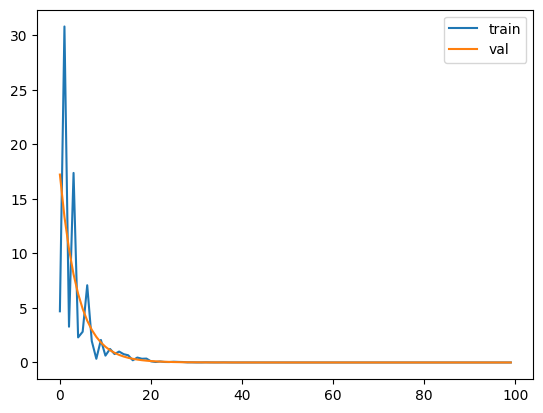

In [29]:
train(100, loader, model, val_x, val_y, print_losses=True)

In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[ 2.0000e+00, -3.0000e+00,  9.5994e-06, -2.0839e-06,  8.3548e-06,
          -1.3881e-05,  2.2458e-05,  1.4237e-05,  2.9735e-05, -1.4589e-05,
           2.0000e+00]], requires_grad=True),
 Parameter containing:
 tensor([-3.0000], requires_grad=True)]

# Evaluate the model on an unseen test set


In [31]:
test_X = torch.randn(10, 10)
test_X = torch.cat((test_X, (test_X[:, 0]* test_X[:, 1])[:,None]), dim=1)
test_y = (2 * test_X[:, 0] - 3) * (test_X[:, 1] + 1)
test_preds = model(test_X)
test_loss = loss_fn(test_preds.squeeze(), test_y)
print(f"Test loss: {test_loss.item()}")

Test loss: 8.81553585685424e-09


# The model is able to converge, and the loss curves look smooth 
- the model has been able to learn all of the coefficients to map the input to the output, despite only being a linear model. 
- We used a feature cross to enable the linear model to represent a higher order feature. 

# We can also try to solve this problem by introducing a nonlinearity to the model.

#### Let's go back to our original dataset without any feature crosses. 

# Make the synthetic dataset and split into train and validation sets. 

In [32]:
X = torch.randn(1000, 10)
y = (2 * X[:, 0] - 3) * (X[:, 1] + 1)
train_x, val_x = X[:800], X[800:]
train_y, val_y = y[:800], y[800:]
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

## Define a nonlinear model
This model will contain two linear layers connected by a ReLU activation function, enabling it to represent nonlinear functions. 

In [33]:
model = torch.nn.Sequential(
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1)
)

In [34]:
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [35]:
optimizer


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [36]:
# Define the data loader
loader = DataLoader(train_dataset, batch_size=500, shuffle=True)

2.518, 1.761


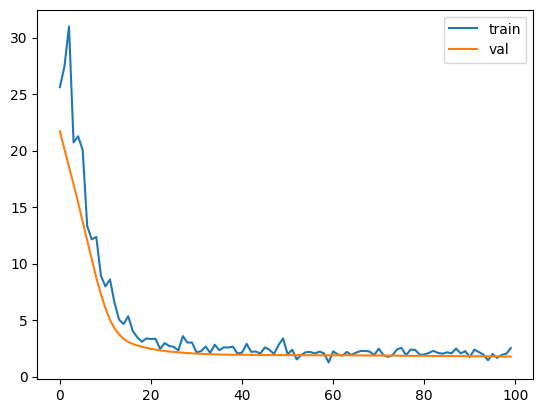

In [37]:
train(100, loader, model, val_x, val_y)

The model converges towards a stable value, but it takes a long time and never reaches zero. This can be explained by the model not describing the mapping function perfectly - it is almost but not quite describing the equation

$y=2X_0X_1 + 2X_0 -3X_1 - 3$

Since we increased the number of layers in the model, interpreting what is going on by looking at the parameters has gone from being trivial to being very difficult. We are looking for coefficients which represent a straight multiplication of $2 * X_0$, $-3 * X_1$ and some way of representing $2*X_0*X_1$


In [38]:
list(model.parameters())

[Parameter containing:
 tensor([[-6.0341e-01,  7.4068e-01,  1.1714e-01,  3.0487e-01,  1.1350e-01,
           1.6252e-01, -3.8328e-01,  2.9286e-01, -1.7268e-01, -1.1349e-01],
         [-9.7725e-01,  1.2587e+00, -9.1938e-02, -1.3213e-01,  2.7093e-02,
          -1.1980e-01,  9.9834e-02, -2.4829e-01,  1.9772e-01, -8.2101e-03],
         [-4.7922e-01,  5.4561e-01,  1.7990e-01, -1.3366e-01, -5.8698e-02,
           2.0070e-01,  1.2817e-01,  2.6042e-02,  7.4049e-02,  1.5992e-02],
         [-1.1129e-01, -3.4661e-01,  1.5593e-02, -3.3927e-02,  3.3553e-03,
          -6.7739e-02,  1.9699e-01, -2.1908e-01, -1.9680e-01,  1.2308e-01],
         [ 6.4029e-04,  1.1276e-01, -2.5297e-01,  2.1831e-01, -1.1878e-01,
          -1.4201e-01,  3.0204e-01, -1.6409e-01, -1.6396e-01,  1.7286e-01],
         [-3.0487e-01,  2.8155e-01,  9.8999e-02, -2.4160e-01, -2.4192e-01,
          -1.1160e-01, -2.1963e-02,  7.1207e-03,  2.8266e-01,  1.1177e-01],
         [-4.3329e-03,  2.6280e-01, -2.4909e-01, -1.4999e-01,  2.7082e-

Perhaps we can work out the correct set of parameters for the model just by thinking about it...

The first node of the first layer needs to carry through the exact values of $X_0$ and $X_1$ so they can be used later.

We also need these $X_0$ and $X_1$ features to be multiplied by the weights 2 and -3 for the linear part of the problem. 

We'd need an overall bias of -3, which is added to the output layer of the model.

Finally need a point in the model where $X_0$ and $X_1$ are multiplied together. This never happens - unless we have a quadratic activation function. We're providing nonlinearities using ReLUs (rectified linear units). A ReLU is like two linear functions (y=x and y=0) joined at a discontinuity at x=0. 

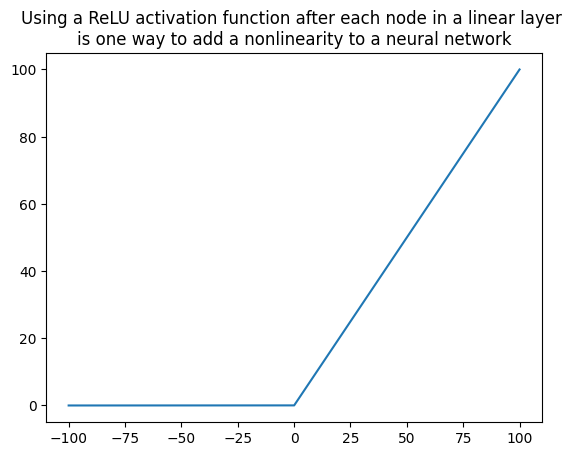

In [47]:
k = torch.linspace(-100, 100, 20000)
relu = torch.relu(k)
plt.plot(k, relu)
plt.title('Using a ReLU activation function after each node in a linear layer \nis one way to add a nonlinearity to a neural network')

plt.show()

0.172, 0.177


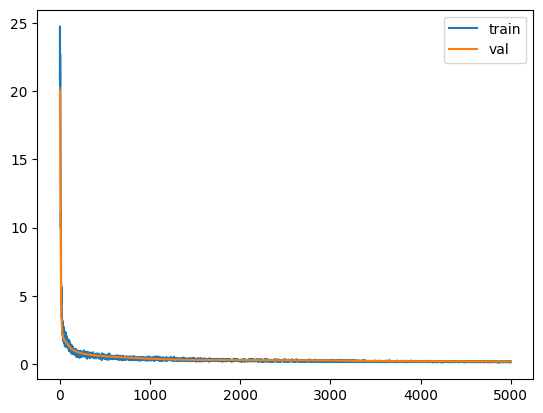

In [48]:
train(5000, loader, model, val_x, val_y)

This model is trained pretty well. Let's make a plot of y vs model(x) and see what shape we get. 

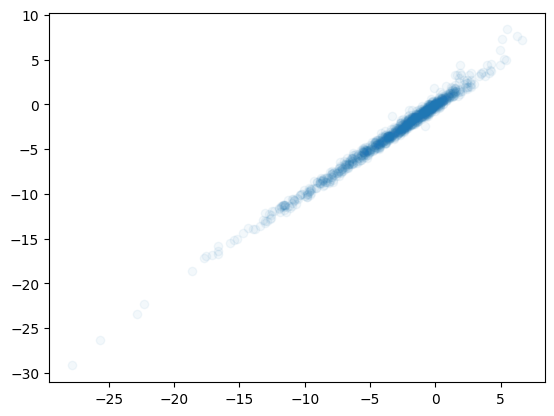

In [52]:
plt.scatter(model(X).detach().numpy(), y, alpha=0.05)

There are outliers visible. After training for 5000 epochs, the model has found a way of approximating our nonlinear function using a combination of coefficients and nonlinear activation functions. It isn't perfect though - since functions which build the model are all linear additions and multiplications by ReLU. 

# Simplify the model to represent $y=x^2$
Having our nonlinearity in the form $X_0X_1$ makes the problem space 3 dimensional, which is harder to plot. If we consider the case for $y=x^2$ we'll be able to see the model's approximation more clearly. 

## Make the synthetic dataset

# Split the dataset into train and validation sets. 

In [447]:
x = torch.linspace(-0.1, 0.1, 500)
x = x[:, None]
y = torch.square(x)

train_dataset = TensorDataset(x,y)

In [448]:
val_x = torch.linspace(-0.1,0.1, 100)
val_x = val_x[:, None]
val_y = torch.square(val_x)

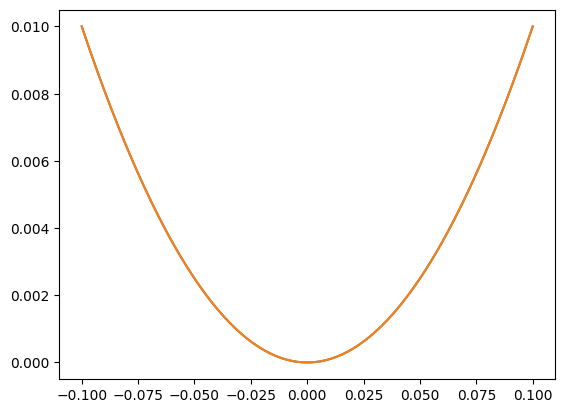

In [449]:
plt.plot(x,y)
plt.plot(val_x,val_y)
plt.show()

## Define a nonlinear model
This model will contain two linear layers connected by a ReLU activation function, enabling it to represent nonlinear functions. 

In [450]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1),
)

In [452]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

In [453]:
# Define the data loader
loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

0.000, 0.000


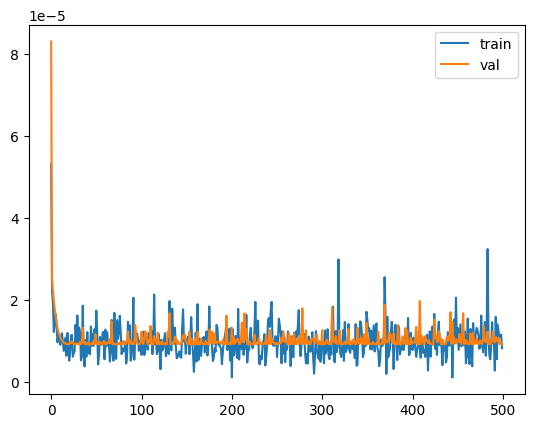

In [454]:
train(500, loader, model, val_x, val_y)

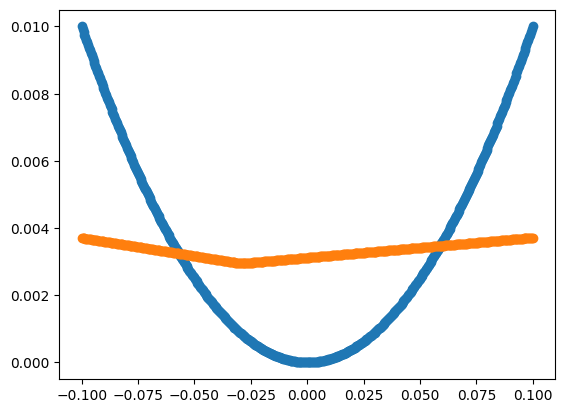

In [456]:
plt.scatter(x,y)
yhat = model(x).detach().numpy()
plt.scatter(x, yhat)

I haven't been able to get the model to train sufficiently for this problem. Here's another blog post showing that it is possible, and that the resulting model doesn't have any smooth segments on its curve:

https://machinelearningmastery.com/neural-networks-are-function-approximators/

# Conclusion

- Linear relationship between input features can be found efficiently by linear neural networks, even if there are multiple overlapping linear features. 
- Higher order functions of the form $y=x^2$ and up, or crosses between input features of the form $X_0X_1$ can only be approximated by neural networks - the nonlinearities are made by adding together a bunch of transformed nonlinear functions. In the case of ReLU, this means that the mapping will be made up of straight line segments. 
- Feature crosses can be used to provide a nonlinear mapping using a linear model. 

### Thanks for reading!